# Feature Extraction

List of tasks performed in this notebook:
- Compute Mel Filterbank and MFCC features step-by-step
- Examine features
- Evaluate correlation between feature
- Compare utterances with Dynamic Time Warping
- Illustrate the discriminative power of the features with respect to words 
- Perform hierarchical clustering of utterances
- Train and analyze a Gaussian Mixture Model of the feature vectors

Authors:
* Damian Valle
* Marc Botet


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fft, ifft, dct
from sklearn.mixture import GaussianMixture
import IPython.display as ipd
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()
data = np.load('lab1_data.npz', allow_pickle=True)['data']

In [3]:
def tidigit2labels(tidigitsarray):
    """
    Return a list of labels including gender, speaker, digit and repetition information for each
    utterance in tidigitsarray. Useful for plots.
    """
    labels = []
    nex = len(tidigitsarray)
    for ex in range(nex):
        labels.append(tidigitsarray[ex]['gender'] + '_' + 
                      tidigitsarray[ex]['speaker'] + '_' + 
                      tidigitsarray[ex]['digit'] + '_' + 
                      tidigitsarray[ex]['repetition'])
    return labels
    
labels = tidigit2labels(data)

In [4]:
def mspec_func(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, samplingrate=20000):
    """Computes Mel Filterbank features.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        samplingrate: sampling rate of the original signal

    Returns:
        N x nfilters array with mel filterbank features (see trfbank for nfilters)
    """
    frames = enframe(samples, winlen, winshift)
    preemph = preemp(frames, preempcoeff)
    windowed = windowing(preemph)
    spec = powerSpectrum(windowed, nfft)
    return logMelSpectrum(spec, samplingrate)

In [5]:
def mfcc_func(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, nceps=13, samplingrate=20000, liftercoeff=22):
    """Computes Mel Frequency Cepstrum Coefficients.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        nceps: number of cepstrum coefficients to compute
        samplingrate: sampling rate of the original signal
        liftercoeff: liftering coefficient used to equalise scale of MFCCs

    Returns:
        N x nceps array with lifetered MFCC coefficients
    """
    mspecs = mspec_func(samples, winlen, winshift, preempcoeff, nfft, samplingrate)
    ceps = cepstrum(mspecs, nceps)
    return lifter(ceps, liftercoeff)

In [6]:
def trfbank(fs, nfft, lowfreq=133.33, linsc=200/3., logsc=1.0711703, nlinfilt=13, nlogfilt=27, equalareas=False):
    """Compute triangular filterbank for MFCC computation.

    Inputs:
    fs:         sampling frequency (rate)
    nfft:       length of the fft
    lowfreq:    frequency of the lowest filter
    linsc:      scale for the linear filters
    logsc:      scale for the logaritmic filters
    nlinfilt:   number of linear filters
    nlogfilt:   number of log filters

    Outputs:
    res:  array with shape [N, nfft], with filter amplitudes for each column.
            (N=nlinfilt+nlogfilt)
    From scikits.talkbox"""
    # Total number of filters
    nfilt = nlinfilt + nlogfilt

    #------------------------
    # Compute the filter bank
    #------------------------
    # Compute start/middle/end points of the triangular filters in spectral
    # domain
    freqs = np.zeros(nfilt+2)
    freqs[:nlinfilt] = lowfreq + np.arange(nlinfilt) * linsc
    freqs[nlinfilt:] = freqs[nlinfilt-1] * logsc ** np.arange(1, nlogfilt + 3)
    if equalareas:
        heights = np.ones(nfilt)
    else:
        heights = 2./(freqs[2:] - freqs[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = np.zeros((nfilt, nfft))
    # FFT bins (in Hz)
    nfreqs = np.arange(nfft) / (1. * nfft) * fs
    for i in range(nfilt):
        low = freqs[i]
        cen = freqs[i+1]
        hi = freqs[i+2]

        lid = np.arange(np.floor(low * nfft / fs) + 1,
                        np.floor(cen * nfft / fs) + 1, dtype=np.int)
        lslope = heights[i] / (cen - low)
        rid = np.arange(np.floor(cen * nfft / fs) + 1,
                        np.floor(hi * nfft / fs) + 1, dtype=np.int)
        rslope = heights[i] / (hi - cen)
        fbank[i][lid] = lslope * (nfreqs[lid] - low)
        fbank[i][rid] = rslope * (hi - nfreqs[rid])

    return fbank

In [7]:
def lifter(mfcc, lifter=22):
    """
    Applies liftering to improve the relative range of MFCC coefficients.

       mfcc: NxM matrix where N is the number of frames and M the number of MFCC coefficients
       lifter: lifering coefficient

    Returns:
       NxM array with lifeterd coefficients
    """
    nframes, nceps = mfcc.shape
    cepwin = 1.0 + lifter/2.0 * np.sin(np.pi * np.arange(nceps) / lifter)
    return np.multiply(mfcc, np.tile(cepwin, nframes).reshape((nframes,nceps)))

In [8]:
def enframe(samples, winlen, winshift):
    """
    Slices the input samples into overlapping windows.

    Args:
        winlen: window length in samples.
        winshift: shift of consecutive windows in samples
    Returns:
        numpy array [N x winlen], where N is the number of windows that fit
        in the input signal
    """
    idx = 0
    ans = []
    while idx < samples.size - winlen:
      ans.append(samples[int(idx):int(idx+winlen)])
      idx += winshift

    return np.array(ans)

In [9]:
def preemp(input, p=0.97):
    """
    Pre-emphasis filter.

    Args:
        input: array of speech frames [N x M] where N is the number of frames and
               M the samples per frame
        p: preemhasis factor (defaults to the value specified in the exercise)

    Output:
        output: array of pre-emphasised speech samples
    Note (you can use the function lfilter from scipy.signal)
    """
    ans = []

    for row in input:
      ans.append(signal.lfilter([1, -p], [1], row))

    return np.array(ans)

In [10]:
def windowing(input):
    """
    Applies hamming window to the input frames.

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
    Output:
        array of windoed speech samples [N x M]
    Note (you can use the function hamming from scipy.signal, include the sym=0 option
    if you want to get the same results as in the example)
    """
    ans = []
    window = signal.hamming(preemph.shape[1], sym=0)

    for row in input:
      ans.append(row * window)

    return np.array(ans)

In [11]:
def powerSpectrum(input, nfft):
    """
    Calculates the power spectrum of the input signal, that is the square of the modulus of the FFT

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
        nfft: length of the FFT
    Output:
        array of power spectra [N x nfft]
    Note: you can use the function fft from scipy.fftpack
    """
    ans = []

    for row in input:
      ans.append( abs(fft(row, nfft))**2 )

    return np.array(ans)

In [12]:
def logMelSpectrum(input, samplingrate):
    """
    Calculates the log output of a Mel filterbank when the input is the power spectrum

    Args:
        input: array of power spectrum coefficients [N x nfft] where N is the number of frames and
               nfft the length of each spectrum
        samplingrate: sampling rate of the original signal (used to calculate the filterbank shapes)
    Output:
        array of Mel filterbank log outputs [N x nmelfilters] where nmelfilters is the number
        of filters in the filterbank
    Note: use the trfbank function provided in lab1_tools.py to calculate the filterbank shapes and
          nmelfilters
    """

    tr_bank = trfbank(samplingrate, 512)

    ans = input @ tr_bank.T
    
    return np.log(np.array(ans))

In [13]:
def cepstrum(input, nceps):
    """
    Calulates Cepstral coefficients from mel spectrum applying Discrete Cosine Transform

    Args:
        input: array of log outputs of Mel scale filterbank [N x nmelfilters] where N is the
               number of frames and nmelfilters the length of the filterbank
        nceps: number of output cepstral coefficients
    Output:
        array of Cepstral coefficients [N x nceps]
    Note: you can use the function dct from scipy.fftpack.realtransforms
    """
    
    return dct(input)[:, :nceps]

In [14]:
def dtw(x, y, dist):
    """Dynamic Time Warping.

    Args:
        x, y: arrays of size NxD and MxD respectively, where D is the dimensionality
              and N, M are the respective lenghts of the sequences
        dist: distance function (can be used in the code as dist(x[i], y[j]))

    Outputs:
        d: global distance between the sequences (scalar) normalized to len(x)+len(y)
        LD: local distance between frames from x and y (NxM matrix)
        AD: accumulated distance between frames of x and y (NxM matrix)
        path: best path thtough AD

    Note that you only need to define the first output for this exercise.
    """
    #TODO
    pass

# Mel-frequency cepstrum coefficients

[]

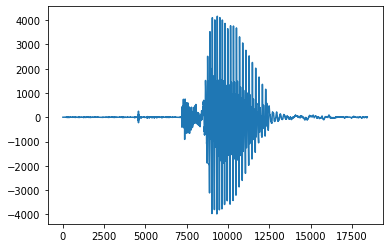

In [15]:
plt.plot(example['samples'])
plt.plot()

## Enframe

Takes as input speech samples, the frame length in samples and the number of samples overlap between consecutive frames and outputs a two dimensional array where each row is a frame of samples.

In [16]:
window_length = 20 #ms
window_shift = 10 #ms

winlen = window_length * example['samplingrate'] / 1000
winshift = window_shift * example['samplingrate'] / 1000

enframed = enframe(example['samples'], winlen, winshift)
(enframed==example['frames']).all()

True

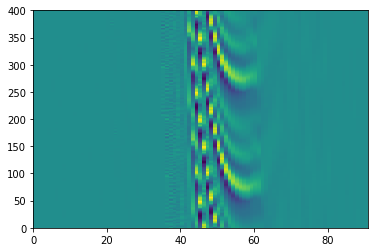

In [19]:
plt.pcolormesh(enframed.T)
plt.show()

## Pre-emphasis

Pre-emphasis is the first part of a noise reduction technique in which a signal's weaker, higher frequencies are boosted before they are transmitted or recorded onto a storage medium.

In [21]:
preemph = preemp(enframed)
(example['preemph']==preemph).all()

True

[]

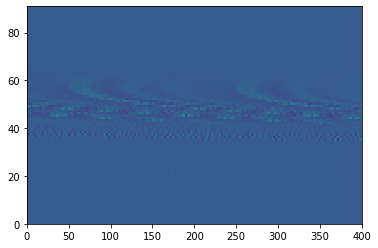

In [22]:
plt.pcolormesh(preemph)
plt.plot()

## Hamming Window

Signals can't be represented with infinetely many samples inside a computer, that's why transforms of windowed functions yield ripples.
The hamming window reduces this ripple, giving you a more accurate idea of the original signal's frequency spectrum.

[]

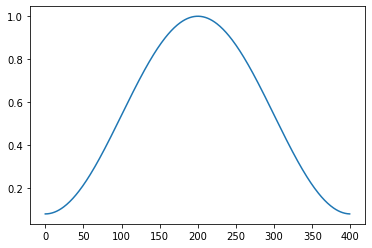

In [23]:
window = signal.hamming(preemph.shape[1], sym=0)
plt.plot(window)
plt.plot()

In [24]:
windowed = windowing(example['preemph'])

In [25]:
(example['windowed']==windowed).all()

True

## Fast Fourier Transform

It converts a signal into individual spectral components and thereby provides frequency information about the signal.

In [26]:
nfft = 512

spec = powerSpectrum(example['windowed'], nfft)

In [27]:
(example['spec']==spec).all()

False

In [28]:
# We add a threshold
(abs(spec - example['spec']) < 1e-6).all()

True

[]

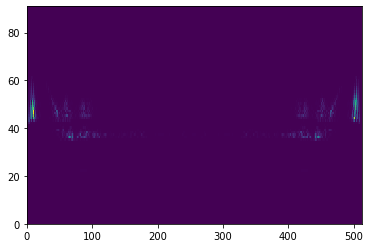

In [29]:
plt.pcolormesh(example['spec'])
plt.plot()

[]

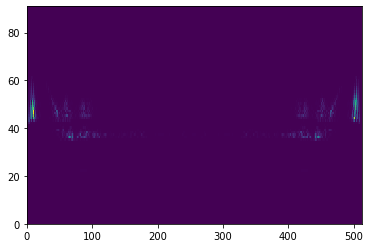

In [30]:
plt.pcolormesh(spec)
plt.plot()

## Mel filterbank log spectrum

(91, 40)


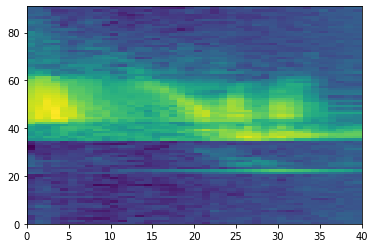

In [31]:
print(example['mspec'].shape)
plt.pcolormesh(example['mspec'])
plt.show()

The distribution of the filters along the frequency axis is condensed towards the low frequencies because the human hearing has higher resolution at lower frequencies.

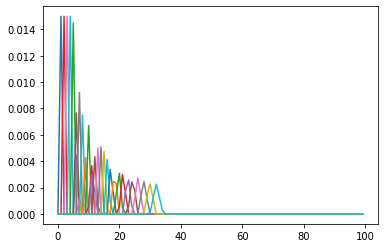

In [32]:
tr_bank = trfbank(data[0]['samplingrate'], 100)
plt.plot(tr_bank.T)
plt.show()

In [33]:
mspec = logMelSpectrum(example['spec'], example['samplingrate'])
(abs(mspec - example['mspec']) < 1e-6).all()

True

## Cosine Transform and Liftering

(91, 13)


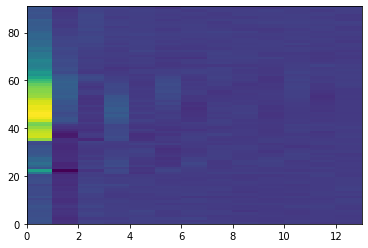

In [34]:
print(example['mfcc'].shape)
plt.pcolormesh(example['mfcc'])
plt.show()

In [35]:
mfcc = cepstrum(example['mspec'], 13)

In [36]:
(abs(mfcc - example['mfcc']) < 1e-6).all()

True

In [37]:
(abs(lifter(mfcc) - example['lmfcc']) < 1e-6).all()

True

# Feature Correlation

First we compute the Mel filterbank features.

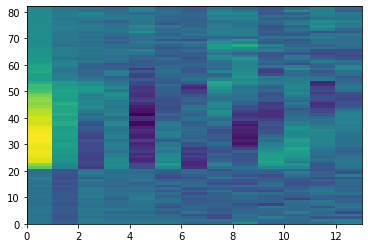

(82, 13)

In [38]:
plt.pcolormesh(mfcc_func(data[0]['samples']))
plt.show()
mfcc_func(data[0]['samples']).shape

In [39]:
concat_mfcc = []
concat_mspec = []
show_img = False

for data_point in data:
  concat_mfcc.append(mfcc_func(data_point['samples']))
  concat_mspec.append(mspec_func(data_point['samples']))
  if show_img:
    plt.pcolormesh(mfcc_func(data_point['samples']))
    plt.show()
    print("Gender: {}\tDigit: {}".format(data_point['gender'], data_point['digit']))

mfcc_concat = np.vstack(tuple(concat_mfcc))
mspec_concat = np.vstack(tuple(concat_mspec))
print(mfcc_concat.shape)
print(mspec_concat.shape)

(3883, 13)
(3883, 40)


In [40]:
r_mfcc = np.corrcoef(mfcc_concat.T)
r_mspec = np.corrcoef(mspec_concat.T)

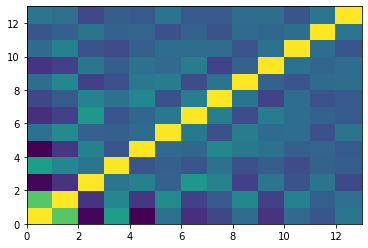

In [41]:
plt.pcolormesh(r_mfcc)
plt.show()

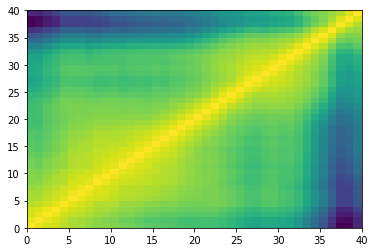

In [42]:
plt.pcolormesh(r_mspec)
plt.show()

# Clustering Speech Segments

In [43]:
ipd.Audio(data[16]["samples"], rate=data[16]["samplingrate"])

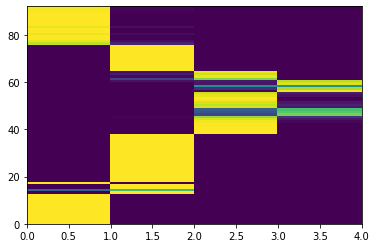

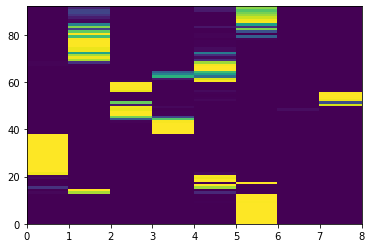

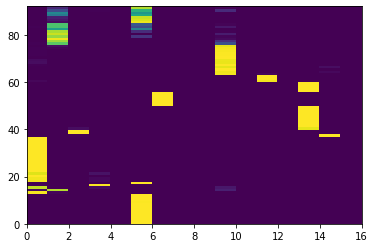

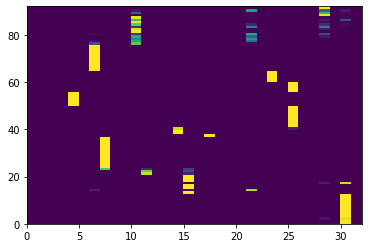

In [44]:
for n_components in [4, 8, 16, 32]:
  gm = GaussianMixture(n_components).fit(mfcc_concat)
  proba = gm.predict_proba(mfcc_func(data[16]["samples"]))
  plt.pcolormesh(proba)
  plt.show()

They are a stable representation.
They roughly correspond to the phonemes.
Fricative is similar men vs women.

7
man


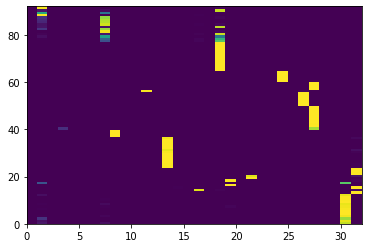

7
man


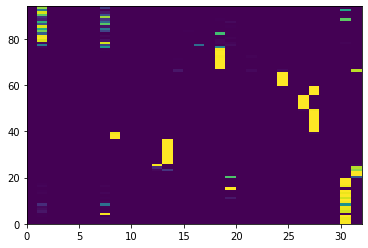

7
woman


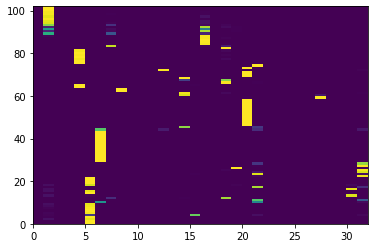

7
woman


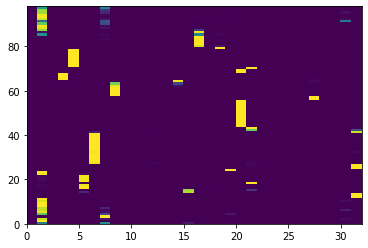

In [ ]:
gm = GaussianMixture(n_components=32).fit(mfcc_concat)

def plot_posteriors(sample_idx):
  print(data[sample_idx]["digit"])
  print(data[sample_idx]["gender"])
  proba = gm.predict_proba(mfcc_func(data[sample_idx]["samples"]))
  plt.pcolormesh(proba)
  plt.show()

for idx in [16, 17, 38, 39]:
  plot_posteriors(idx)

# Comparing Utterances

In [53]:
def dtw(utt1, utt2, dist):
    """
    Dynamic Time Warping.

    Args:
        x, y: arrays of size NxD and MxD respectively, where D is the dimensionality
              and N, M are the respective lenghts of the sequences
        dist: distance function (can be used in the code as dist(x[i], y[j]))

    Outputs:
        d: global distance between the sequences (scalar) normalized to len(x)+len(y)
        LD: local distance between frames from x and y (NxM matrix)
        AD: accumulated distance between frames of x and y (NxM matrix)
        path: best path thtough AD

    Note that you only need to define the first output for this exercise.
    """

    LocD = dist(utt1, utt2)
    AccD = np.zeros_like(LocD)

    for elem in np.nditer(AccD):
      elem = np.inf
    AccD[0, 0] = 0

    for h in range(1, AccD.shape[0]):
      for k in range(1, AccD.shape[1]):
        AccD[h, k] = LocD[h, k] + min(AccD[h-1, k], AccD[h-1, k-1], AccD[h, k-1])

    return AccD

In [54]:
def euclidean_mfcc(utt1, utt2):
  """
  Given two utterances of length N and M respectively, 
  compute an [N × M] matrix of local Euclidean distances between each MFCC 
  vector in the first utterance and each MFCC vector in the second utterance.

  output: matrix
  """
  mfcc_utt1 = mfcc_func(utt1)
  mfcc_utt2 = mfcc_func(utt2)

  matrix = np.zeros((mfcc_utt1.shape[0], mfcc_utt2.shape[0]))

  for i, utt1 in enumerate(mfcc_utt1):
    for j, utt2 in enumerate(mfcc_utt2):
      matrix[i][j] = np.sqrt(np.sum((utt1-utt2)**2))
  
  return matrix

In [55]:
m = euclidean_mfcc(data[16]['samples'], data[17]['samples'])

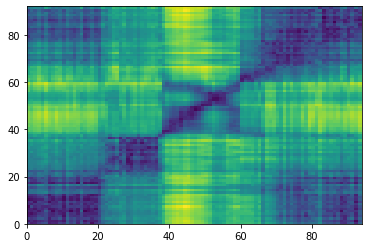

In [56]:
plt.pcolormesh(m)
plt.show()

In [57]:
dtt = dtw(data[16]['samples'], data[17]['samples'], euclidean_mfcc)

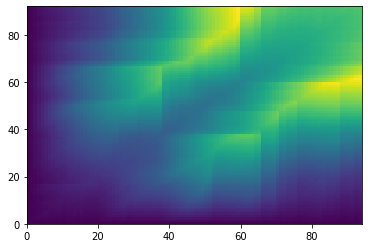

In [58]:
plt.pcolormesh(dtt)
plt.show()

In [ ]:
pairw_dist = np.zeros((len(data), len(data)))

for i in range(len(data)):
  print("{}/44".format(i))
  for j in range(len(data)):
    pairw_dist[i, j] = dtw(data[i]['samples'], data[j]['samples'], euclidean_mfcc)[-1][-1]

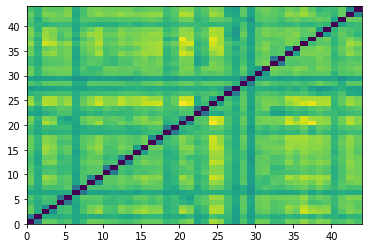

In [ ]:
plt.pcolormesh(pairw_dist)
plt.show()

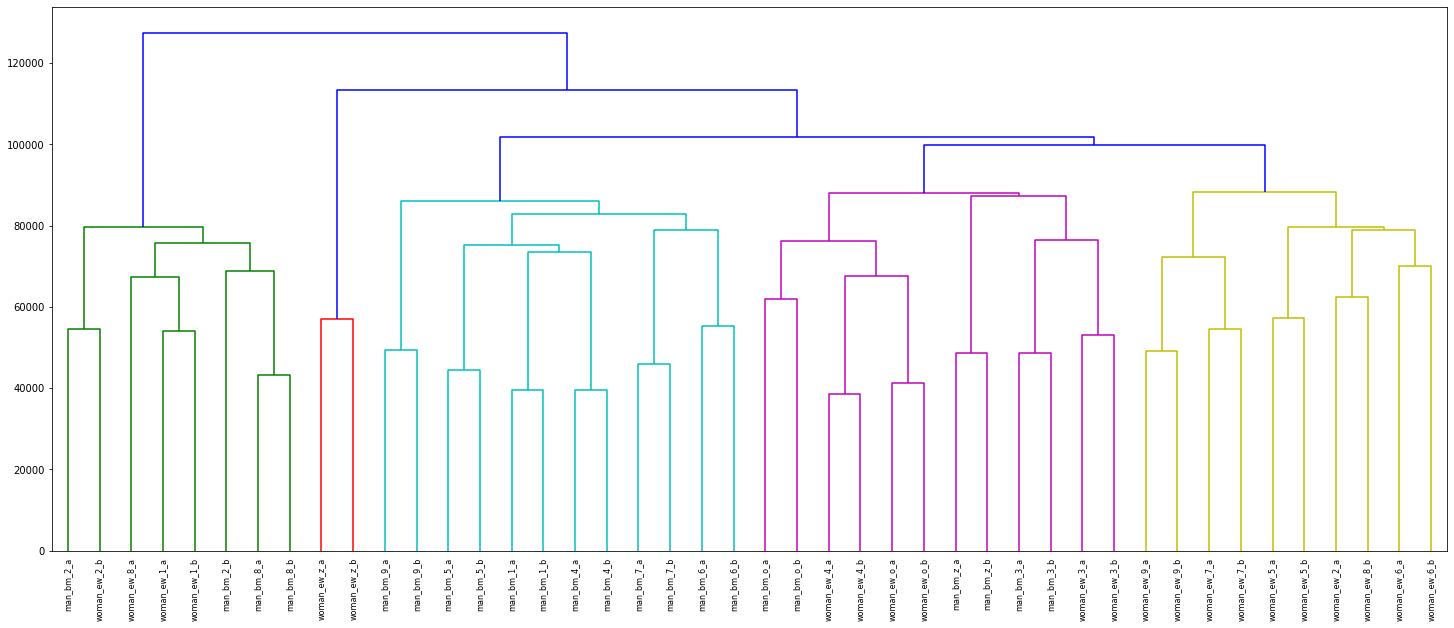

In [ ]:
Z = linkage(pairw_dist, method='complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, labels=labels)
plt.show()